# VANGUARD AB TEST


## METADATA HELP

This comprehensive set of fields will guide your analysis, helping you unravel the intricacies of client behavior and preferences.

- **client_id**: Every client’s unique ID.
- **variation**: Indicates if a client was part of the experiment.
- **visitor_id**: A unique ID for each client-device combination.
- **visit_id**: A unique ID for each web visit/session.
- **process_step**: Marks each step in the digital process.
- **date_time**: Timestamp of each web activity.
- **clnt_tenure_yr**: Represents how long the client has been with Vanguard, measured in years.
- **clnt_tenure_mnth**: Further breaks down the client’s tenure with Vanguard in months.
- **clnt_age**: Indicates the age of the client.
- **gendr**: Specifies the client’s gender.
- **num_accts**: Denotes the number of accounts the client holds with Vanguard.
- **bal**: Gives the total balance spread across all accounts for a particular client.
- **calls_6_mnth**: Records the number of times the client reached out over a call in the past six months.
- **logons_6_mnth**: Reflects the frequency with which the client logged onto Vanguard’s platform over the last six months.


In [163]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
from cleaning import *
from mining import *
from db_handling import *
import pandas as pd
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest


In [165]:
# Load environment variables
load_dotenv()

True

### Load Configuration

In [166]:
# Load config.yaml
config = parse_config()

{'database_name': 'vanguard_ab', 'refresh_db': False, 'tables': {'clients': {'sources': [{'path': 'data/df_final_demo.txt', 'url': 'https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt'}], 'separator': ',', 'dropna': True, 'columns': {'client_id': {'original_name': 'client_id', 'data_type': 'INTEGER', 'primary_key': True, 'pandas_dtype': 'int64'}, 'client_since_month': {'original_name': 'clnt_tenure_mnth', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'client_age': {'original_name': 'clnt_age', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'gender': {'original_name': 'gendr', 'data_type': 'CHAR(1)', 'pandas_dtype': 'category', 'valid_categories': ['U', 'M', 'F'], 'fallback_category': 'U'}, 'number_of_accounts': {'original_name': 'num_accts', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'balance': {'original_name': 'bal', 'data_type': 'FLOAT', 'pandas_dtype': 'float64'}, 'calls_6_months': 

## Data Mining

In [167]:
# Creates a dictionary of all imported dataframes
dataframes = { name:import_data_from_config(config, name) for name in config['tables']}

## Data Cleaning

In [168]:
#TODO: don't impose categories?

In [169]:
# Rename columns
dataframes = rename_columns(dataframes, config)

In [170]:
# Select columns
dataframes = select_columns(dataframes, config)

In [171]:
display_dataFrames(dataframes,'head','shape')

clients:
clients - Head:


,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0


clients - Shape:


(70609, 8)

experiment:
experiment - Head:


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


experiment - Shape:


(70609, 2)

visits:
visits - Head:


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


visits - Shape:


(755405, 5)

### Separation

In [172]:
client_df = dataframes['clients']
experiment_df = dataframes['experiment']
visits_df = dataframes['visits']
display (client_df, experiment_df, visits_df)

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
70604,7993686,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,68.0,M,3.0,475114.69,4.0,4.0


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


In [173]:
# drop the nulls from clients, but keep the list of the drops

nulls_client_id = client_df[client_df.isna().any(axis=1)]['client_id']
nulls_client_id

4164     7402828
8316      355337
8677     8412164
9583     4666211
13444    2222915
18066    4876926
25961    5277910
28432    7616759
35323    8191345
43518    1227228
46076    8611797
47189    5144725
49846    1037867
63701    1618749
66219    6021001
Name: client_id, dtype: int64

In [174]:
client_df = client_df.dropna(axis=0)
client_df

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
70604,7993686,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,68.0,M,3.0,475114.69,4.0,4.0


In [175]:
display(experiment_df['variation'].value_counts(dropna = False))
# keep NaN for general analysis of clients, but drop them from everywhere for test analysis

variation
Test       26968
Control    23532
NaN        20109
Name: count, dtype: int64

In [176]:
# client_df, experiment_df, visit_df -> for general analysis
# new_client_df, new_experiment_df, new_visit_dfn -> for test/control analysis   experiment_df_null = 
nulls_in_experiment = experiment_df[experiment_df.isna().any(axis=1)]['client_id']
nulls_in_experiment

50500    5459747
50501    8031000
50502    1847030
50503    9713157
50504    7775828
          ...   
70604    2443347
70605    8788427
70606     266828
70607    1266421
70608    9895983
Name: client_id, Length: 20109, dtype: int64

In [177]:
# new df removing client ID that are null in experiment

display(experiment_df.count())
new_experiment_df = experiment_df[~experiment_df['client_id'].isin(nulls_in_experiment)]
display(new_experiment_df.count())

new_experiment_df = new_experiment_df[~new_experiment_df['client_id'].isin(nulls_client_id)]
display(new_experiment_df.count())
display(new_experiment_df.isna().sum())



client_id    70609
variation    50500
dtype: int64

client_id    50500
variation    50500
dtype: int64

client_id    50487
variation    50487
dtype: int64

client_id    0
variation    0
dtype: int64

In [178]:
display(visits_df)
new_visits_df = visits_df[~visits_df['client_id'].isin(nulls_in_experiment)]
display(new_visits_df)
display(new_visits_df.isna().sum())

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

In [179]:
display(client_df)
new_client_df = client_df[~client_df['client_id'].isin(nulls_in_experiment)]
display(new_client_df)

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
70604,7993686,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,68.0,M,3.0,475114.69,4.0,4.0


,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
50495,1780858,262.0,68.5,M,3.0,372100.59,6.0,9.0
50496,6967120,260.0,68.5,M,3.0,4279873.38,6.0,9.0
50497,5826160,249.0,56.5,F,2.0,44837.16,2.0,5.0
50498,8739285,229.0,69.5,F,2.0,44994.24,1.0,4.0


### End separation

In [180]:
dataframes['clients'] = new_client_df.copy()
dataframes['experiment'] = new_experiment_df.copy()
dataframes['visits'] = new_visits_df.copy()

In [181]:
# Data Categorizing
dataframes = clean_categorical_data(dataframes, config)

In [182]:
#Convert types
dataframes = convert_types(dataframes, config)

In [183]:
display_dataFrames(dataframes, 'head', 'shape', 'cat_count')

clients:
clients - Head:


,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73,60,U,2,45105.30,6,9
1,2304905,94,58,U,2,110860.30,6,9
2,1439522,64,32,U,2,52467.79,6,9
3,1562045,198,49,M,2,67454.65,3,6
4,5126305,145,33,F,2,103671.75,0,3


clients - Shape:


(50487, 8)

clients - Cat_count:


,gender
gender,
U,17282
M,16947
F,16258


experiment:
experiment - Head:


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


experiment - Shape:


(50487, 2)

experiment - Cat_count:


,variation
variation,
Test,26961
Control,23526


visits:
visits - Head:


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


visits - Shape:


(626883, 5)

visits - Cat_count:


,process_step
process_step,
start,202439
step_1,135733
step_2,110366
step_3,92714
confirm,85631


In [184]:
client_df = dataframes['clients']
experiment_df = dataframes['experiment']
visits_df = dataframes['visits']


### SQL EXPORT

In [185]:
if config['refresh_db']:

    db_password = os.getenv('SQL_PASSWORD')

    # Create database if it doesn't exist
    engine = create_db(db_password, config)

    # Export tables to database if refresh is set to true
    export_dataframes_to_sql(engine, dataframes)

    # Import data from database
    dataframes = import_all_tables_from_sql(engine)

### Local Caching

In [186]:
""" # Save files locally in an untracked folder
export_dataframes_to_csv(dataframes) """

' # Save files locally in an untracked folder\nexport_dataframes_to_csv(dataframes) '

In [187]:
#TODO CAREFUL DATA WONT BE PROPERLY CATEGORIZED / TYPED run after : convert_types(dataframes, config)
""" clients_df = pd.read_csv('data/cleaned/clients.csv')
experiment_df = pd.read_csv('data/cleaned/experiment.csv')
visits_df = pd.read_csv('data/cleaned/visits.csv') """

" clients_df = pd.read_csv('data/cleaned/clients.csv')\nexperiment_df = pd.read_csv('data/cleaned/experiment.csv')\nvisits_df = pd.read_csv('data/cleaned/visits.csv') "

## CLEAN FRAMES

In [188]:
display('clients :',client_df, 'experiment :',experiment_df, 'visits :',visits_df)

experiment_df['variation'].value_counts()


'clients :'

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73,60,U,2,45105.30,6,9
1,2304905,94,58,U,2,110860.30,6,9
2,1439522,64,32,U,2,52467.79,6,9
3,1562045,198,49,M,2,67454.65,3,6
4,5126305,145,33,F,2,103671.75,0,3
...,...,...,...,...,...,...,...,...
50495,1780858,262,68,M,3,372100.59,6,9
50496,6967120,260,68,M,3,4279873.38,6,9
50497,5826160,249,56,F,2,44837.16,2,5
50498,8739285,229,69,F,2,44994.24,1,4


'experiment :'

,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


'visits :'

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


variation
Test       26961
Control    23526
Name: count, dtype: int64

## Data Exploration

### Merge frames

In [189]:
# Added variation column to visits for easier analysis
visits_variations = visits_df.merge(experiment_df, on='client_id', how='inner')
display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test
...,...,...,...,...,...,...
321190,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test
321191,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control
321192,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control
321193,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control


In [190]:
# Merge clients and visits for demographic analysis
visits_variations = visits_variations.merge(client_df, on='client_id', how='inner')
display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,64,79,U,2,189023.86,1,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,64,79,U,2,189023.86,1,4
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,64,79,U,2,189023.86,1,4
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,64,79,U,2,189023.86,1,4
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,64,79,U,2,189023.86,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321190,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test,121,55,U,2,153238.83,3,6
321191,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control,252,34,M,3,141808.05,6,9
321192,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control,252,34,M,3,141808.05,6,9
321193,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control,252,34,M,3,141808.05,6,9


### Sort visits by time

In [191]:
# sort by visit_id and date_time to see the process steps in order
visits_variations = visits_variations.sort_values(by=['visit_id', 'date_time'], ascending=[True, True])
display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
116328,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9
116327,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9
256722,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9
256721,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9
256720,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104029,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,227,58,F,2,1056775.54,6,9
104028,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,227,58,F,2,1056775.54,6,9
104027,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,227,58,F,2,1056775.54,6,9
104026,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,227,58,F,2,1056775.54,6,9


## OUTLIERS

### Time taken

In [192]:
visits_variations['time_taken'] = visits_variations.groupby('visit_id')['date_time'].diff().dt.total_seconds()
visits_variations['time_taken'] = visits_variations['time_taken'].fillna(0)

display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken
116328,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0
116327,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9,52.0
256722,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0
256721,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9,16.0
256720,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104029,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,227,58,F,2,1056775.54,6,9,0.0
104028,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,227,58,F,2,1056775.54,6,9,11.0
104027,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,227,58,F,2,1056775.54,6,9,54.0
104026,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,227,58,F,2,1056775.54,6,9,44.0


In [193]:
# add a column to show the total time taken for each visit_id
visits_variations['total_time_taken'] = visits_variations.groupby('visit_id')['time_taken'].transform('sum')
display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
116328,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0,52.0
116327,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9,52.0,52.0
256722,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0,242.0
256721,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9,16.0,242.0
256720,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9,9.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104029,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,227,58,F,2,1056775.54,6,9,0.0,118.0
104028,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,227,58,F,2,1056775.54,6,9,11.0,118.0
104027,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,227,58,F,2,1056775.54,6,9,54.0,118.0
104026,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,227,58,F,2,1056775.54,6,9,44.0,118.0


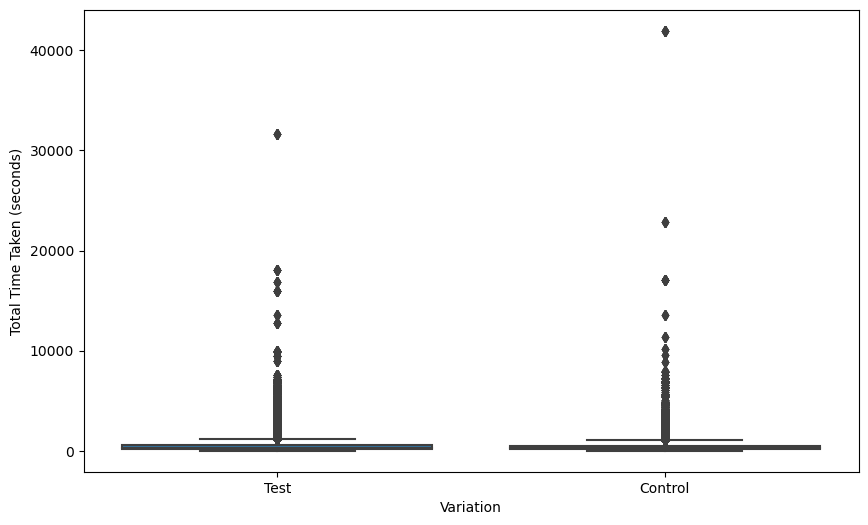

In [194]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='total_time_taken', data=visits_variations)
plt.xlabel('Variation')
plt.ylabel('Total Time Taken (seconds)')
plt.show()

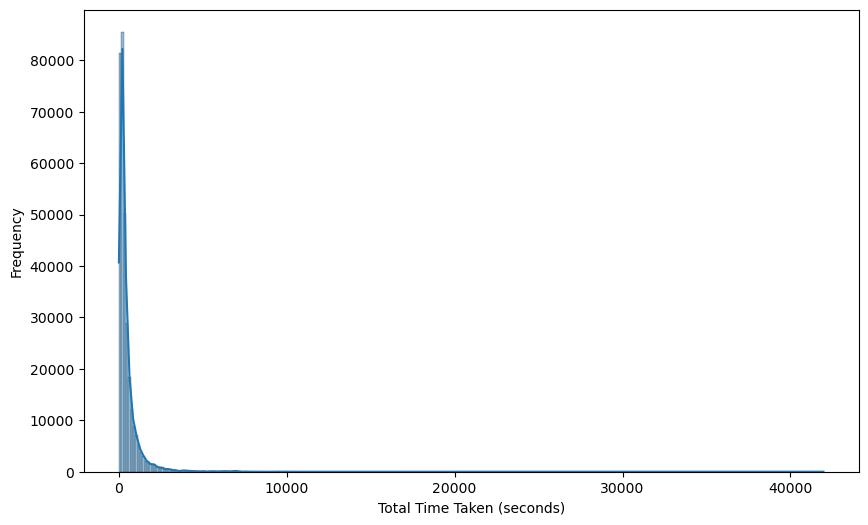

In [195]:
plt.figure(figsize=(10, 6))
sns.histplot(data=visits_variations, x='total_time_taken', kde=True, bins=300)
plt.xlabel('Total Time Taken (seconds)')
plt.ylabel('Frequency')
plt.show()

In [196]:
def tukeys_test_outliers(my_data, method="show"):
    data = my_data.copy()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds for the outliers
    lower_bound = Q1 - 1.2 * IQR
    upper_bound = Q3 + 1 * IQR
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    if method == "show":
        return outliers
    elif method == "replace":
        median = data.median()
        data.loc[outliers.index] = median
        return data
    elif method == "delete":
        index_drop = outliers.index
        data_no_outliers = data.drop(index_drop)
        display(data_no_outliers)
        return data_no_outliers.index

In [197]:
variations_outliers = tukeys_test_outliers(visits_variations['total_time_taken'], method="show")
display(variations_outliers)
display(variations_outliers.describe())

visits_variations = visits_variations[~visits_variations['total_time_taken'].isin(variations_outliers)]
display(visits_variations)
display(visits_variations.describe())

18533    1017.0
18532    1017.0
18531    1017.0
18530    1017.0
18529    1017.0
          ...  
99139    1050.0
99138    1050.0
99137    1050.0
99136    1050.0
99135    1050.0
Name: total_time_taken, Length: 38887, dtype: float64

count    38887.000000
mean      1884.712500
std       1620.778831
min        919.000000
25%       1104.000000
50%       1397.000000
75%       2067.000000
max      41965.000000
Name: total_time_taken, dtype: float64

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
116328,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0,52.0
116327,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9,52.0,52.0
256722,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0,242.0
256721,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9,16.0,242.0
256720,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9,9.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104029,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,227,58,F,2,1056775.54,6,9,0.0,118.0
104028,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,227,58,F,2,1056775.54,6,9,11.0,118.0
104027,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,227,58,F,2,1056775.54,6,9,54.0,118.0
104026,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,227,58,F,2,1056775.54,6,9,44.0,118.0


,client_id,date_time,client_since_month,client_age,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
count,2.823080e+05,282308,282308.000000,282308.000000,282308.000000,2.823080e+05,282308.000000,282308.000000,282308.000000,282308.000000
mean,5.014789e+06,2017-04-20 05:01:46.170260992,151.358665,47.617790,2.267233,1.603581e+05,3.256248,6.292974,46.469806,283.165776
min,5.550000e+02,2017-03-15 00:19:28,33.000000,17.000000,1.000000,2.378944e+04,0.000000,3.000000,0.000000,0.000000
25%,2.521514e+06,2017-04-04 13:01:34.500000,82.000000,34.000000,2.000000,4.069813e+04,1.000000,4.000000,2.000000,124.000000
50%,5.056707e+06,2017-04-12 14:03:03.500000,136.000000,49.000000,2.000000,6.803868e+04,3.000000,6.000000,19.000000,230.000000
75%,7.477039e+06,2017-05-01 11:57:29.249999872,193.000000,60.000000,2.000000,1.485375e+05,6.000000,9.000000,57.000000,398.000000
max,9.999832e+06,2017-06-20 23:57:06,669.000000,96.000000,7.000000,1.632004e+07,6.000000,9.000000,905.000000,918.000000
std,2.875148e+06,NaN,82.880523,15.627023,0.545004,3.569071e+05,2.195350,2.182489,76.744788,215.016718


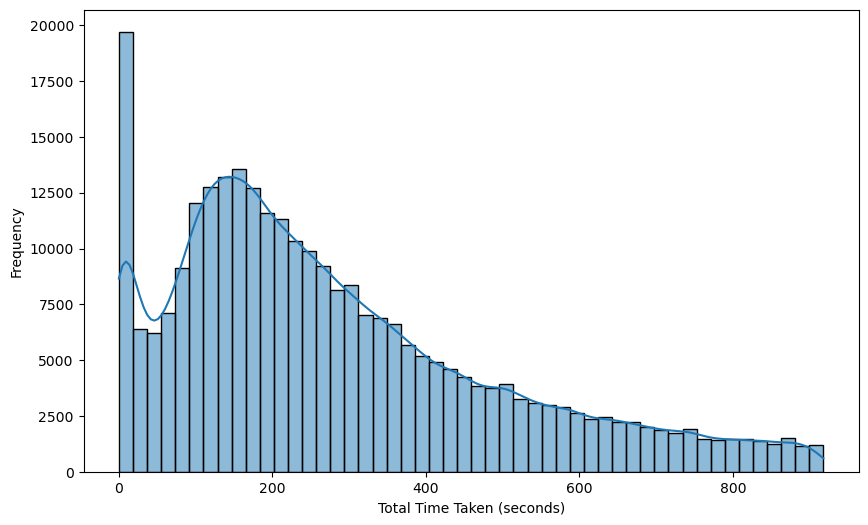

In [198]:
plt.figure(figsize=(10, 6))
sns.histplot(data=visits_variations, x='total_time_taken', kde=True, bins=50)
plt.xlabel('Total Time Taken (seconds)')
plt.ylabel('Frequency')
plt.show()

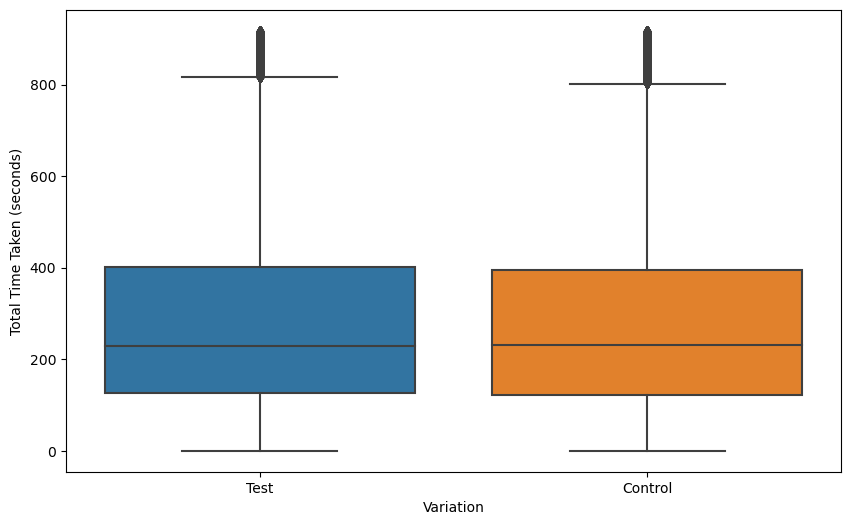

count    282308.000000
mean        283.165776
std         215.016718
min           0.000000
25%         124.000000
50%         230.000000
75%         398.000000
max         918.000000
Name: total_time_taken, dtype: float64

In [199]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='total_time_taken', data=visits_variations)
plt.xlabel('Variation')
plt.ylabel('Total Time Taken (seconds)')
plt.show()

visits_variations['total_time_taken'].describe()

### Correlation matrix

,client_id,client_since_month,client_age,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
client_id,1.000000,0.002820,-0.003827,-0.008377,0.018953,-0.003511,-0.003186,-0.000773,0.005015
client_since_month,0.002820,1.000000,0.341636,0.166595,0.180915,0.079922,0.085755,0.008173,-0.016513
client_age,-0.003827,0.341636,1.000000,0.016021,0.182379,0.080020,0.088513,0.172550,0.117029
number_of_accounts,-0.008377,0.166595,0.016021,1.000000,0.237934,0.268656,0.271895,-0.072213,-0.087430
balance,0.018953,0.180915,0.182379,0.237934,1.000000,0.157753,0.161316,0.002140,-0.027531
calls_6_months,-0.003511,0.079922,0.080020,0.268656,0.157753,1.000000,0.994737,-0.052557,-0.084453
logons_6_month,-0.003186,0.085755,0.088513,0.271895,0.161316,0.994737,1.000000,-0.049562,-0.081868
time_taken,-0.000773,0.008173,0.172550,-0.072213,0.002140,-0.052557,-0.049562,1.000000,0.597466
total_time_taken,0.005015,-0.016513,0.117029,-0.087430,-0.027531,-0.084453,-0.081868,0.597466,1.000000


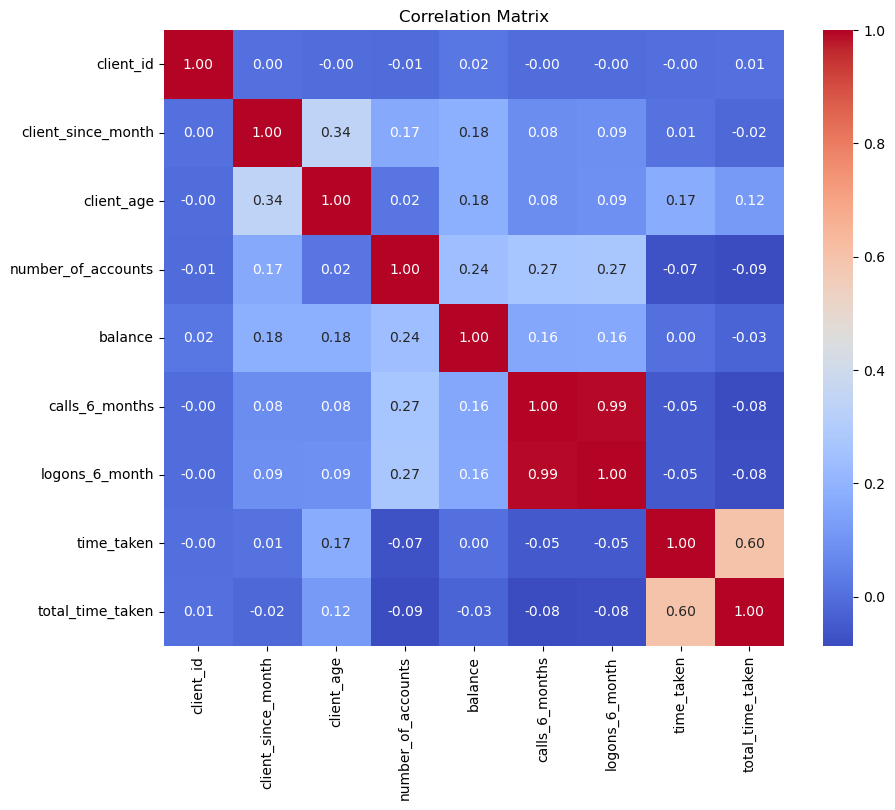

In [200]:
# select only the happy paths confirmed steps
confirmed_steps = visits_variations[visits_variations['process_step'] == 'confirm']

# Select numerical columns
numerical_data = confirmed_steps.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Display the correlation matrix
display(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Count visits

In [201]:
# Total number of visits per variation to calculate the success rate later
number_of_visits = visits_variations.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits)


variation
Test       34536
Control    30288
Name: visit_id, dtype: int64

### Happy Path

In [202]:
# function to filter visits with our happy path
def filter_visits_with_happy_path(df):
    def check_sequence(group):
        steps = list(group['process_step'])
        return steps == ['start', 'step_1', 'step_2', 'step_3', 'confirm']

    df_filtered = df.groupby('visit_id').filter(check_sequence)
    return df_filtered


In [203]:
happy_paths = filter_visits_with_happy_path(visits_variations)

display(happy_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
263622,2478628,754122351_18568832435,100022086_87870757897_149620,start,2017-05-23 20:44:01,Test,198,47,F,2,32456.28,2,5,0.0,180.0
263621,2478628,754122351_18568832435,100022086_87870757897_149620,step_1,2017-05-23 20:44:23,Test,198,47,F,2,32456.28,2,5,22.0,180.0
263620,2478628,754122351_18568832435,100022086_87870757897_149620,step_2,2017-05-23 20:45:08,Test,198,47,F,2,32456.28,2,5,45.0,180.0
263619,2478628,754122351_18568832435,100022086_87870757897_149620,step_3,2017-05-23 20:46:01,Test,198,47,F,2,32456.28,2,5,53.0,180.0
263618,2478628,754122351_18568832435,100022086_87870757897_149620,confirm,2017-05-23 20:47:01,Test,198,47,F,2,32456.28,2,5,60.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87362,829911,648229874_89449279372,999984454_18731538378_781808,start,2017-03-29 11:18:33,Test,82,84,M,3,229828.31,6,9,0.0,154.0
87361,829911,648229874_89449279372,999984454_18731538378_781808,step_1,2017-03-29 11:18:51,Test,82,84,M,3,229828.31,6,9,18.0,154.0
87360,829911,648229874_89449279372,999984454_18731538378_781808,step_2,2017-03-29 11:19:32,Test,82,84,M,3,229828.31,6,9,41.0,154.0
87359,829911,648229874_89449279372,999984454_18731538378_781808,step_3,2017-03-29 11:20:23,Test,82,84,M,3,229828.31,6,9,51.0,154.0


In [204]:
# Total number of success per variation
number_of_successes = happy_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_successes)


variation
Test       10229
Control     8750
Name: visit_id, dtype: int64

In [205]:
# calculate the success rate per variation
success_rate = number_of_successes / number_of_visits
display(success_rate)

variation
Test       0.296184
Control    0.288893
Name: visit_id, dtype: float64

In [206]:
#frequency tables

### Non Happy Path

In [214]:
# function to filter out visits with start->confirm but no happy path in between them
def filter_non_happy_path_visits(df):
    def check_non_consecutive(group):
        steps = list(group['process_step'])
        if steps[0] == 'start' and steps[-1] == 'confirm':
            if steps != ['start', 'step_1', 'step_2', 'step_3', 'confirm']:
                return True
        return False

    df_filtered = df.groupby('visit_id').filter(check_non_consecutive)
    return df_filtered

In [215]:
non_happy_paths = filter_non_happy_path_visits(visits_variations)

display(non_happy_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
256722,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0,242.0
256721,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9,16.0,242.0
256720,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9,9.0,242.0
256719,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,88,23,M,2,26436.73,6,9,14.0,242.0
256718,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,88,23,M,2,26436.73,6,9,6.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227615,4449968,842902495_57580498240,999976049_95772503197_182554,step_1,2017-04-04 12:52:26,Test,252,53,F,4,124701.46,2,5,136.0,728.0
227614,4449968,842902495_57580498240,999976049_95772503197_182554,step_2,2017-04-04 12:53:01,Test,252,53,F,4,124701.46,2,5,35.0,728.0
227613,4449968,842902495_57580498240,999976049_95772503197_182554,step_3,2017-04-04 12:54:54,Test,252,53,F,4,124701.46,2,5,113.0,728.0
227612,4449968,842902495_57580498240,999976049_95772503197_182554,step_3,2017-04-04 12:59:35,Test,252,53,F,4,124701.46,2,5,281.0,728.0


In [159]:
number_of_visits_non_happy = non_happy_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits_non_happy)

variation
Test       5777
Control    4323
Name: visit_id, dtype: int64

In [160]:
success_rate_non_happy = number_of_visits_non_happy / number_of_visits
display(success_rate_non_happy)
# proportion of lost people is greater in test group.

variation
Test       0.167275
Control    0.142730
Name: visit_id, dtype: float64

### Error path

In [220]:
without_happy_path = visits_variations[~visits_variations['visit_id'].isin(happy_paths['visit_id'])]

error_paths = without_happy_path[~without_happy_path['visit_id'].isin(non_happy_paths['visit_id'])]

display(error_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
116328,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0,52.0
116327,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9,52.0,52.0
255494,105007,676020267_36602664238,100030127_47967100085_936361,start,2017-03-22 11:07:49,Control,118,35,F,2,34897.47,3,6,0.0,0.0
29552,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:41:51,Control,202,78,M,2,146827.14,5,8,0.0,132.0
29551,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:43:16,Control,202,78,M,2,146827.14,5,8,85.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104029,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,227,58,F,2,1056775.54,6,9,0.0,118.0
104028,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,227,58,F,2,1056775.54,6,9,11.0,118.0
104027,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,227,58,F,2,1056775.54,6,9,54.0,118.0
104026,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,227,58,F,2,1056775.54,6,9,44.0,118.0


In [221]:
number_of_visits_error_path = error_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits_error_path)

variation
Test       18530
Control    17215
Name: visit_id, dtype: int64

In [222]:
success_rate_error_paths = number_of_visits_error_path / number_of_visits
display(success_rate_error_paths)

variation
Test       0.536542
Control    0.568377
Name: visit_id, dtype: float64

## Analysis

In [207]:
# PROPORTION Z TEST ----Happy Paths---- Proportion of successes is greater in Test group than in Control group
# H0: Proportion of complete steps in TEST group <= Proportion of complete steps in CONTROL group
# H1: Pt > Pc
alpha = 0.05

successes = [number_of_successes['Test'], number_of_successes['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

proportions_ztest(successes, just_visits, alternative = "larger")

(2.0352043056274574, 0.020915160006684145)

In [229]:
# PROPORTION Z TEST ----Non Happy Paths----
# H0: Proportion of complete steps in TEST group <= Proportion of complete steps in CONTROL group
# H1: Pt > Pc
alpha = 0.05

successes = [number_of_visits_non_happy['Test'], number_of_visits_non_happy['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

proportions_ztest(successes, just_visits, alternative = "larger")

(8.597090350229601, 4.088130781661023e-18)

In [228]:
# PROPORTION Z TEST ----Error Paths---- 
# H0: Proportion of visits in TEST group >= Proportion of visits in CONTROL group
# H1: Pt < Pc
alpha = 0.05

successes = [number_of_visits_error_path['Test'], number_of_visits_error_path['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

proportions_ztest(successes, just_visits, alternative = "smaller")

(-8.131136859118284, 2.1264142956905858e-16)

### T-Test for total time

In [230]:
# TWO SAMPLE T TEST ---- Average total_time of success is smaller in Test group than in Control group
import scipy.stats as st
# H0: average time it took to complete steps in test group is greater or equal to one in control group 
#       (Mean_time_test>=Mean_time_control)
# H1: average time it took to complete steps is less in test group than in control group 
#       (Mean_time_test<Mean_time_control)
alpha=0.05
df_test = happy_paths[happy_paths['variation']=='Test']['total_time_taken']
df_control = happy_paths[happy_paths['variation']=='Control']['total_time_taken']
st.ttest_ind(df_test,df_control, equal_var=False, alternative = 'less')

TtestResult(statistic=-39.82953314729064, pvalue=0.0, df=88968.65901398103)

In [231]:
average_time_per_variation = happy_paths.groupby('variation').agg({'total_time_taken': 'mean'})
average_time_per_variation

,total_time_taken
variation,
Test,227.703783
Control,269.110971


In [232]:
# average total time without outliers
avg_total_time = happy_paths['total_time_taken'].mean()
display(avg_total_time)

246.7939828231203

In [161]:
#TODO: consider binning / pd.cut / qcut for numerical data
#TODO: correlation matrix
#TODO: tukeys_test_outliers

In [162]:
# check back and forth between steps, lost?
# 

## Visualizations

## Conclusions